2022-05-30 01:33:10.488332: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2022-05-30 01:33:10.488389: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: spk
2022-05-30 01:33:10.488401: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: spk
2022-05-30 01:33:10.488556: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.129.6
2022-05-30 01:33:10.488590: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.103.1
2022-05-30 01:33:10.488599: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 470.103.1 does not match DSO version 470.129.6 -- cannot find working devices in this configuration
2022-05-30 01:33:10.489030: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binar

239/240 [============================>.] - ETA: 0s - d_loss: 0.5901 - g_loss: 0.7023 - d_acc: 0.7748

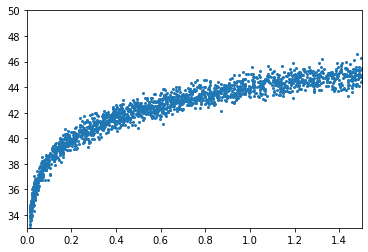

240/240 [==============================] - 13s 46ms/step - d_loss: 0.5898 - g_loss: 0.7039 - d_acc: 0.7750 - val_d_loss: 0.5503 - val_g_loss: 0.7717 - val_d_acc: 0.8000


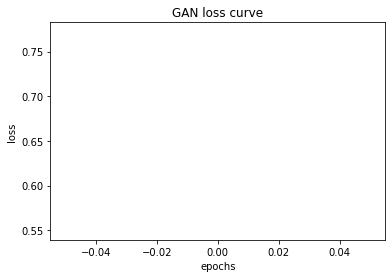

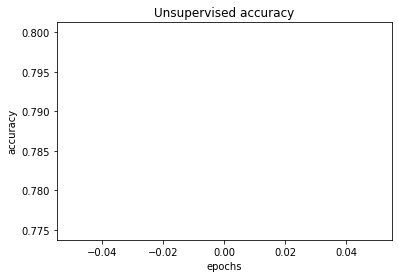

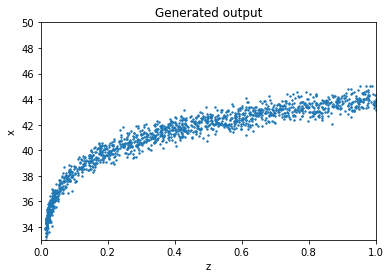

Press enter to continue...


''

In [1]:
import os
import sys
from shutil import copyfile
import json
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping

# add parent directory of project to system path, to access all the packages in project, sys.path.append appends are not permanent
sys.path.append(os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath('train.py')))))))

from src.model.GAN.Generator import Generator
from src.model.GAN.Discriminator import Discriminator
from src.model.GAN.GAN import GAN
from src.model.GAN.dark_energy.GANMonitor import GANMonitor

readlines = ""
with open('Params.json') as file:
    readlines = file.read() 

Params = json.loads(readlines) 
latent_dim = Params['latent_dim'] 
epochs = Params['epochs']
patience = Params['patience']
lr_gen = Params['lr_gen']
beta_1_gen = Params['beta_1_gen']
lr_disc = Params['lr_disc']
beta_1_disc= Params['beta_1_disc']
batch_size = Params['batch_size']
input_dim = Params['input_dim']
output_dim = Params['output_dim']
n_classes = Params['n_classes']
train_size = Params['train_size']
buffer_size = train_size 
outdir = Params['outdir'] 

if not os.path.isdir(outdir):
    os.makedirs(outdir)
if not os.path.isdir(os.path.join(outdir, 'fig')):
    os.mkdir(os.path.join(outdir, 'fig')) 
if not os.path.isdir(os.path.join(outdir, 'ckpt')):
    os.mkdir(os.path.join(outdir, 'ckpt'))
if not os.path.isdir(os.path.join(outdir, 'log')):
    os.mkdir(os.path.join(outdir, 'log'))

copyfile('Params.json',os.path.join(outdir, 'Params.json'))

z = np.genfromtxt('../../../data/dark_energy_models/z.csv', dtype=np.float32)
x_real = np.genfromtxt('../../../data/dark_energy_models/x_real.csv', dtype=np.float32)

# normalize the y data, very important for GAN training
scaler = StandardScaler()
scaler.fit(x_real[0].reshape(1,-1))
x_real = scaler.transform(x_real)

# split into test, validation, and training sets
x_train, x_test = train_test_split(x_real, test_size=0.2)
x_train, x_val = train_test_split(x_train, test_size=0.2)

train_dataset = ( 
    tf.data.Dataset
        .from_tensor_slices((x_train))
        .shuffle(buffer_size, reshuffle_each_iteration=True)
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
)

val_dataset = (
    tf.data.Dataset
        .from_tensor_slices((x_val))
        .batch(batch_size)
)

test_dataset = (
    tf.data.Dataset
        .from_tensor_slices((x_test))
        .batch(batch_size)
)

generator = Generator(latent_dim)
discriminator = Discriminator(output_dim)

gan = GAN(latent_dim, generator, discriminator, z, scaler)
gan.compile(
    tf.keras.optimizers.Adam(learning_rate=lr_gen, beta_1=beta_1_gen),
    tf.keras.optimizers.Adam(learning_rate=lr_disc, beta_1=beta_1_disc), 
    tf.keras.losses.BinaryCrossentropy(from_logits=True),
)

gan_checkpoint_path = os.path.join(outdir,"ckpt/gan.ckpt")
g_checkpoint_path = os.path.join(outdir,"ckpt/generator.ckpt")
d_checkpoint_path = os.path.join(outdir,"ckpt/discriminator.ckpt")

csvlogger_path = os.path.join(outdir,"log/log.txt")

callbacks = [
    #ModelCheckpoint(checkpoint_path, monitor='val_d_loss', save_best_only=True, save_weights_only=True, verbose=1),
    #EarlyStopping(monitor='val_d_loss', patience=patience, verbose=1),
    CSVLogger(csvlogger_path, separator=',', append=True),
    GANMonitor()
]

history = gan.fit(
    train_dataset, 
    epochs=epochs, 
    validation_data = val_dataset,
    callbacks = callbacks
)

generator.save_weights(g_checkpoint_path)
discriminator.save_weights(d_checkpoint_path)
gan.save_weights(gan_checkpoint_path)

# load the best model
# generator.load_weights(g_checkpoint_path)
# discriminator.load_weights(d_checkpoint_path)
gan.load_weights(gan_checkpoint_path)

# number of epochs, early stopped or not
epochs = len(history.history['d_loss'])

plt.figure()
plt.plot(history.history['g_loss'], '-', label='g_loss')
plt.plot(history.history['val_g_loss'], '--', label='val_g_loss')
plt.plot(history.history['d_loss'], '-', label='d_loss')
plt.plot(history.history['val_d_loss'], '--', label='val_d_loss')
plt.title('GAN loss curve')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.savefig(os.path.join(outdir,'fig/loss_curve.png'))
plt.draw()
plt.pause(0.001)
#plt.show()

plt.figure()
plt.plot(history.history['d_acc'], label='d_acc')
plt.plot(history.history['val_d_acc'], label='val_d_acc')
plt.title('Unsupervised accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.savefig(os.path.join(outdir, 'fig/unsupervised_accuracy.png'))
plt.draw()
plt.pause(0.001)
#plt.show()

x = gan.generator(tf.random.normal((1,latent_dim)))
x = scaler.inverse_transform(x)
plt.figure()
plt.scatter(z, np.reshape(x, (output_dim) ), s=2)
plt.title('Generated output')
plt.xlabel('z')
plt.ylabel('x')
plt.xlim(0,1)
plt.ylim(33,50.)
plt.savefig(os.path.join(outdir, 'fig/sample_out.png'))
plt.draw()
plt.pause(0.001)
#plt.show()

input('Press enter to continue...')
